MediaGamma - Take Home Test
======

Qikai Gu

July 17, 2018


The test is about building a CTR prediction model with one of provided datasets. 
I picked [https://www.kaggle.com/c/avazu-ctr-prediction](https://www.kaggle.com/c/avazu-ctr-prediction).

It's expected to:
- finish the test in 2-3 hours
- return the results in 2 weeks but the sooner the better
- build an end-to-end pipeline for the task
- showcase my understanding of various aspects of ML: ETL, model building and selection, evaluation, etc.
- develop in python (jupyter notebooks) with reasonable comments
- use version control with appropriate commit messages

Last updated: July 29, 2018

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import xlearn as xl
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.feature_extraction.text import FeatureHasher, HashingVectorizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import PredefinedSplit, GridSearchCV
import scipy
from scipy.special import logit, expit
import matplotlib.pyplot as plt
import gc

%matplotlib inline

### Loading data

In [2]:
# Use only 'train.gz' here as we need labeled data to evaluate our models.
df = pd.read_csv('input/train.gz', # nrows=100000,
                 compression='gzip', dtype={'id': str}, index_col='id')

In [3]:
pd.set_option('display.max_columns', 100)
df.head()

,click,hour,C1,banner_pos,site_id,site_domain,site_category,app_id,app_domain,app_category,device_id,device_ip,device_model,device_type,device_conn_type,C14,C15,C16,C17,C18,C19,C20,C21
id,,,,,,,,,,,,,,,,,,,,,,,
1000009418151094273,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,ddd2926e,44956a24,1,2,15706,320,50,1722,0,35,-1,79
10000169349117863715,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,96809ac8,711ee120,1,0,15704,320,50,1722,0,35,100084,79
10000371904215119486,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,b3cf8def,8a4875bd,1,0,15704,320,50,1722,0,35,100084,79
10000640724480838376,0,14102100,1005,0,1fbe01fe,f3845767,28905ebd,ecad2386,7801e8d9,07d7df22,a99f214a,e8275b8f,6332421a,1,0,15706,320,50,1722,0,35,100084,79
10000679056417042096,0,14102100,1005,1,fe8cc448,9166c161,0569f928,ecad2386,7801e8d9,07d7df22,a99f214a,9644d0bf,779d90c2,1,0,18993,320,50,2161,0,35,-1,157


In [4]:
print('dataset shape: \t{}'.format(df.shape))

dataset shape: 	(40428967, 23)


### Preprocessing & Feature engineering

Check class balance, it seems the class imbalance is not so bad.

In [5]:
df.click.value_counts()

0    33563901
1     6865066
Name: click, dtype: int64

In [6]:
m0, m1 = df.click.value_counts()

Show features and types

In [7]:
pd.set_option('display.max_rows', 30)
df.dtypes

click                int64
hour                 int64
C1                   int64
banner_pos           int64
site_id             object
site_domain         object
site_category       object
app_id              object
app_domain          object
app_category        object
device_id           object
device_ip           object
device_model        object
device_type          int64
device_conn_type     int64
C14                  int64
C15                  int64
C16                  int64
C17                  int64
C18                  int64
C19                  int64
C20                  int64
C21                  int64
dtype: object

Check if there's any NaN values

In [8]:
for col in df.columns:
    print('{:20}: {}'.format(col, df[col].hasnans))

click               : False
hour                : False
C1                  : False
banner_pos          : False
site_id             : False
site_domain         : False
site_category       : False
app_id              : False
app_domain          : False
app_category        : False
device_id           : False
device_ip           : False
device_model        : False
device_type         : False
device_conn_type    : False
C14                 : False
C15                 : False
C16                 : False
C17                 : False
C18                 : False
C19                 : False
C20                 : False
C21                 : False


Negative samples downsampling

As the provided data is 10 days click-through data. I will use the first 8 days as traning set, 9th day as valid set and the last day as test set.

In [9]:
df.hour.unique()

array([14102100, 14102101, 14102102, 14102103, 14102104, 14102105,
       14102106, 14102107, 14102108, 14102109, 14102110, 14102111,
       14102112, 14102113, 14102114, 14102115, 14102116, 14102117,
       14102118, 14102119, 14102120, 14102121, 14102122, 14102123,
       14102200, 14102201, 14102202, 14102203, 14102204, 14102205,
       14102206, 14102207, 14102208, 14102209, 14102210, 14102211,
       14102212, 14102213, 14102214, 14102215, 14102216, 14102217,
       14102218, 14102219, 14102220, 14102221, 14102222, 14102223,
       14102300, 14102301, 14102302, 14102303, 14102304, 14102305,
       14102306, 14102307, 14102308, 14102309, 14102310, 14102311,
       14102312, 14102313, 14102314, 14102315, 14102316, 14102317,
       14102318, 14102319, 14102320, 14102321, 14102322, 14102323,
       14102400, 14102401, 14102402, 14102403, 14102404, 14102405,
       14102406, 14102407, 14102408, 14102409, 14102410, 14102411,
       14102412, 14102413, 14102414, 14102415, 14102416, 14102

In [10]:
neg_ids = df[df.click == 0].index
np.random.seed(42)
drop_indices = np.random.choice(neg_ids, m0 - m1, replace=False)
df.drop(drop_indices, inplace=True)

Define Train/Valid/Test indices

In [11]:
train_ids = df[(df.hour >= 14102100) & (df.hour < 14102900)].index
valid_ids = df[(df.hour >= 14102900) & (df.hour < 14103000)].index
test_ids = df[df.hour >= 14103000].index

train_indices = df.index.get_indexer(train_ids)
valid_indices = df.index.get_indexer(valid_ids)
test_indices = df.index.get_indexer(test_ids)

# define combined train and val set for cross-validation
train_val_ids = np.concatenate([train_ids, valid_ids])
train_val_indices = np.concatenate([train_indices, valid_indices])

Add hour as a new feature

In [12]:
df['hour_h'] = df.hour.apply(lambda x: x % 100)

In [13]:
label_path = 'label.csv'
label_file = Path(label_path)
if label_file.is_file():
    label_df = pd.read_csv(label_path).set_index('id')
else:
    label_df = df[['click']]
    label_df.to_csv(label_path)

Plot the top value counts of the features

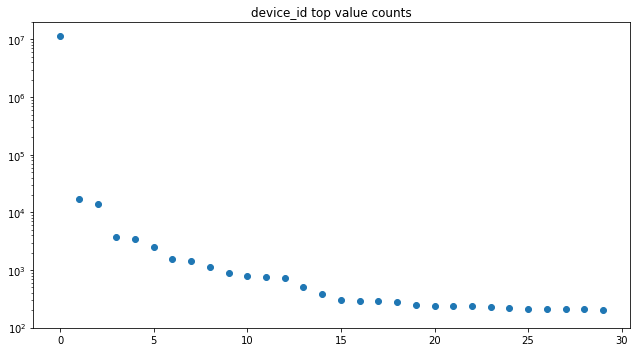

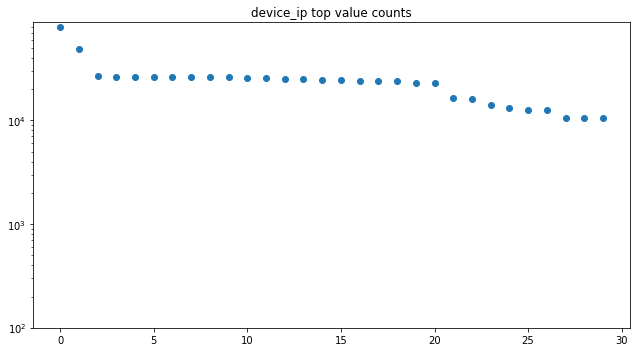

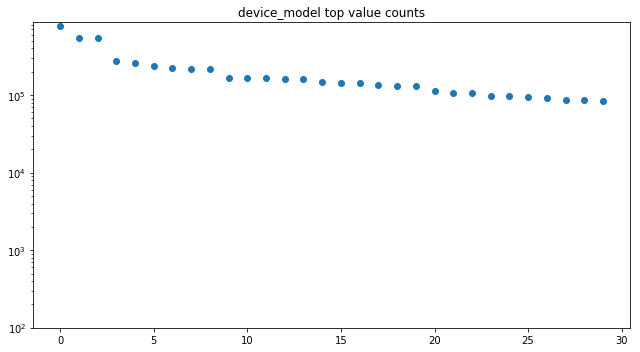

In [14]:
def plot_value_counts(series, title='', size=30):
    cnts = series.values[:size]
    x = range(len(cnts))
    plt.plot(x, cnts, 'o')
    plt.yscale('log')
    plt.ylim(1e2)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plt.rcParams['figure.figsize'] = (9.0, 5.0)
for col in ['device_id', 'device_ip', 'device_model']:
    plot_value_counts(df[col].value_counts(), title='{} top value counts'.format(col))

In [15]:
fields = df.columns[1:]

Print some more information about device.

In [16]:
for col in ['device_type', 'device_conn_type']:
    print(df[col].value_counts())

1    12651076
0      825804
4      217294
5       35951
2           7
Name: device_type, dtype: int64
0    12162191
2     1035000
3      523225
5        9716
Name: device_conn_type, dtype: int64


It looks good, there aren't too many levels.

### Train test split

Test set is randomly selected. I use a dictionary to store sub training sets. To time reason, I only put 6 subsets, but we can add more subsets if needed.

In [17]:
%%time

filepath = 'dataset.npz'
dataset_file = Path(filepath)
if dataset_file.is_file():
    sparse_matrix = scipy.sparse.load_npz(filepath)
else:
    vectors = []
    for c in fields:
        n_features = min(1000, df[c].nunique())
        h = HashingVectorizer(n_features=n_features, binary=True, norm=None, lowercase=False)
        sparse_vector = h.transform(df[c].astype(str))
        vectors.append(sparse_vector)
    sparse_matrix = scipy.sparse.hstack(vectors).tocsr()
    scipy.sparse.save_npz(filepath, sparse_matrix)

CPU times: user 5.2 s, sys: 752 ms, total: 5.95 s
Wall time: 5.97 s


### Building and training models

I will use train a Logistic Regression model and a XGBoost model and evaluate them with ROC AUC scores. For FFM model, I previously used the xLearn framework to build and train the model, but as it's not very stable and non-deterministic for multi-threading for the current version, I won't use it in this notebook.

Logistic Regression model

In [18]:
%%time

lr = LogisticRegression(solver='saga')
lr.fit(sparse_matrix[train_indices, :], df.loc[train_ids].click)

CPU times: user 9min 15s, sys: 3.92 s, total: 9min 19s
Wall time: 9min 19s


In [19]:
print('Train auc:')
roc_auc_score(df.loc[train_ids].click, 
              lr.predict_proba(sparse_matrix[train_indices, :])[:, 1])

Train auc:


0.7467497237177491

In [20]:
print('Valid auc')
roc_auc_score(df.loc[valid_ids].click, 
              lr.predict_proba(sparse_matrix[valid_indices, :])[:, 1])

Valid auc


0.7182220623200812

In [21]:
pred_lr = lr.predict_proba(sparse_matrix[test_indices, :])[:, 1]

In [22]:
roc_auc_score(df.loc[test_ids].click, pred_lr)

0.7139361091527545

XGBoost model

In [23]:
xgb_model = xgb.XGBClassifier(n_estimators=1000, 
                              early_stopping_rounds=10,
                              learning_rate=0.3, 
                              n_jobs=-1, 
                              random_state=42)

parameters = {'max_depth': [7, 9],
              'subsample': [0.8, 0.9],
              'colsample_bytree': [0.8]}

gs_xgb = GridSearchCV(xgb_model, parameters, cv=[(train_indices, valid_indices)], 
                      scoring='roc_auc', verbose=2)
gs_xgb.fit(sparse_matrix[train_val_indices, :], label_df.loc[train_val_ids].click)

Fitting 1 folds for each of 4 candidates, totalling 4 fits
[CV] colsample_bytree=0.8, max_depth=7, subsample=0.8 ................
[CV] . colsample_bytree=0.8, max_depth=7, subsample=0.8, total=44.2min
[CV] colsample_bytree=0.8, max_depth=7, subsample=0.9 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 46.7min remaining:    0.0s


[CV] . colsample_bytree=0.8, max_depth=7, subsample=0.9, total=43.6min
[CV] colsample_bytree=0.8, max_depth=9, subsample=0.8 ................
[CV] . colsample_bytree=0.8, max_depth=9, subsample=0.8, total=57.1min
[CV] colsample_bytree=0.8, max_depth=9, subsample=0.9 ................
[CV] . colsample_bytree=0.8, max_depth=9, subsample=0.9, total=56.7min


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed: 211.9min finished


GridSearchCV(cv=[(array([       0,        1, ..., 11038512, 11038513]), array([11038514, 11038515, ..., 12299305, 12299306]))],
       error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, early_stopping_rounds=10, gamma=0,
       learning_rate=0.3, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [7, 9], 'subsample': [0.8, 0.9], 'colsample_bytree': [0.8]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=2)

In [24]:
gs_xgb.best_score_

0.7495953565751019

In [25]:
gs_xgb.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, early_stopping_rounds=10, gamma=0,
       learning_rate=0.3, max_delta_step=0, max_depth=7,
       min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
       nthread=None, objective='binary:logistic', random_state=42,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.8)

In [26]:
pred_xgb = gs_xgb.predict_proba(sparse_matrix[test_indices, :])[:, 1]

In [27]:
roc_auc_score(label_df.loc[test_ids].click, pred_xgb)

0.741085047022664

### Evaluation

I use AUC as evaluation metric. This metric evaluates the ranking ability of the CTR, which can reduce the impact of bias.

In [28]:
y_true = label_df.loc[test_ids].click.values

fpr_lr, tpr_lr, _ = roc_curve(y_true, pred_lr)
roc_auc_lr = auc(fpr_lr, tpr_lr)

fpr_xgb, tpr_xgb, _ = roc_curve(y_true, pred_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

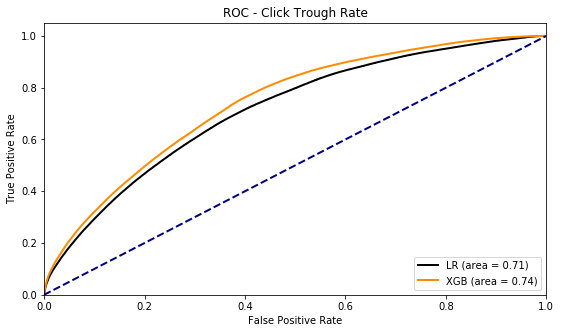

In [29]:
plt.figure()
lw = 2
plt.plot(fpr_lr, tpr_lr, color='black',
         lw=lw, label='LR (area = %0.2f)' % roc_auc_lr)
plt.plot(fpr_xgb, tpr_xgb, color='darkorange',
         lw=lw, label='XGB (area = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Click Trough Rate')
plt.legend(loc="lower right")
plt.show()

Without compound features, XGBoost (0.74) performs slightly better than Logistic Regression (0.71).